# Projektmappe - Grab, Klöble, Ricker

Innerhalb der folgenden Projektmappe gehen wir nach dem CRISP-DM Standardprozess vor, der sich in die folgenden Schritte unterteilt und iterativ erfolgt.

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Weitere Details lassen sich in unserer Dokumentation finden.

## 0. Import aller benötigten Bibliotheken und Daten

Zunächst werden jedoch alle benötigten Bibliotheken und Daten importiert, sodass folgend mit diesen gearbeitet werden kann.

In [93]:
# Installieren der Bibliotheken:

%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [94]:
# Importieren der Bibliotheken:

import importlib
from Anforderungen import init_notebook

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [95]:
# Laden des Datasets:

importlib.reload(init_notebook)

dataset = init_notebook.get_initial_dataset()

## 1. Business Unterstanding

Zum bisherigen Zeitpunkt werden Patienten anhand einer Vielzahl von Kriterien in verschiedene Kohorten eingeteilt. 

Das Ermitteln der Ausprägungen dieser Kriterien bei den einzelnen Patienten ist jedoch sehr kostspielig, insbesondere wenn es um die Abfrage von Blutbildparametern geht. Jeder Parameter verursacht Kosten, und die Anzahl der Parameter beeinflusst die Bearbeitungszeit im Labor. Daraus ergibt sich das Ziel, die Anzahl der abgefragten Kriterien zu reduzieren, um sowohl Kosten als auch Zeit zu sparen, ohne dabei die Qualität der Kohorteneinteilung zu beeinträchtigen. 

Nach Analysen des Robert Koch-Instituts ([Quelle](https://www.rki.de/DE/Content/Gesundheitsmonitoring/Themen/Rauchen/Rauchexposition_epidstudien.html)) wird davon ausgegangen, dass der Raucherstatus das bedeutendste Kriterium für die Bestimmung des Gesundheitsrisikos und somit auch für die Kohorteneinteilung ist. 

Deshalb wird in der folgenden Projektmappe, einem Jupyter Notebook, versucht, die Anzahl der Kriterien zu minimieren, indem lediglich Features selektiert werden, die mit dem Raucherstatus korrelieren. Dadurch können Algorithmen trainiert werden, die die gegebene Antwort der Patienten auf die Frage des Raucherstatus validieren sollen.

## 2. Data Understanding



In [96]:
# Ausgabe der Daten:

dataset.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


Zur weiteren Arbeit mit dem Datensatz bietet es sich an, dessen Spalten in aussagekräftigere Titel umzubenennen.

In [97]:
# Umbenennen der Spalten in aussagekräftigere Benennungen und in Deutsch:

dataset = dataset.rename(columns={'sex': 'Geschlecht', 'age': 'Alter', 'height': 'Größe', 'weight': 'Gewicht', 'waistline': 'Hüftumfang', 'sight_left': 'Sehkraft_links', 'sight_right': 'Sehkraft_rechts', 'hear_left': 'Hörkraft_links', 'hear_right': 'Hörkraft_rechts', 'SBP': 'Systolischer Blutdruck', 'DBP': 'Diastolischer Blutdruck', 'BLDS': 'Nüchterner Blutzucker', 'tot_chole': 'Totale Cholesterin', 'HDL_chole': 'HDL_Cholesterin', 'LDL_chole': 'LDL_Cholesterin', 'triglyceride': 'Triglycerid', 'hemoglobin': 'Hämoglobin', 'urine_protein': 'Urin_Proteine', 'serum_creatinine': 'Serum_Kreatinin', 'SGOT_AST': 'SGOT_AST', 'SGOT_ALT': 'SGOT_ALT', 'gamma_GTP': 'gamma_GTP', 'SMK_stat_type_cd': 'Raucher_Status', 'DRK_YN': 'Trinker'})

Mit der Funktion check_df wird ein Überblick über den Datensatz erzeugt. 

In unserer Dokumentation findet sich im Abschnitt "Datensatz" eine tabellarische Darstellung der einzelnen Spalten zusammen mit entsprechenden Erläuterungen. 
Alle entsprechenden Erkenntnisse werden im darauffolgenden Abschnitt "Verwendung im Datensatz" erläutert. 

In [98]:
# Funktion zur Darstellung von Informationen über den Datensatz: 

def check_df(dataset):
    """
    Perform a quick examination of a DataFrame, including its shape, data types, head, missing values, duplicated rows, quantiles, and number of unique values.

    Args:
        dataframe (pd.DataFrame): The DataFrame to be examined.

    Returns:
        None
    """
    print("##################### Shape #####################")
    print(dataset.shape)
    print("\n##################### Types #####################")
    print(dataset.dtypes)
    print("\n##################### NA #####################")
    print(dataset.isnull().sum())
    print("\n##################### Missing #####################")
    print(dataset.isnull().any())
    print("\n##################### Duplicated Rows #####################")
    print(dataset.duplicated().sum())
    print("\n##################### Quantiles #####################")
    print(dataset.describe().T)
    print("\n##################### Number of Unique Values #####################")
    for col in dataset.columns:
        print(col, dataset[col].nunique())


check_df(dataset)

##################### Shape #####################
(991346, 24)

##################### Types #####################
Geschlecht                  object
Alter                        int64
Größe                        int64
Gewicht                      int64
Hüftumfang                 float64
Sehkraft_links             float64
Sehkraft_rechts            float64
Hörkraft_links             float64
Hörkraft_rechts            float64
Systolischer Blutdruck     float64
Diastolischer Blutdruck    float64
Nüchterner Blutzucker      float64
Totale Cholesterin         float64
HDL_Cholesterin            float64
LDL_Cholesterin            float64
Triglycerid                float64
Hämoglobin                 float64
Urin_Proteine              float64
Serum_Kreatinin            float64
SGOT_AST                   float64
SGOT_ALT                   float64
gamma_GTP                  float64
Raucher_Status             float64
Trinker                     object
dtype: object

##################### NA ######

Aus dieser Darstellung lassen sich bereits einige auffällige Datenpunkte identifizieren:

- Ein Hüftumfang von 999 cm scheint nicht plausibel zu sein.
- Die maximalen Werte der Spalten Sehkraft_links und Sehkraft_rechts weichen stark vom Mittelwert ab.
- Der maximale Wert der Spalte Nüchterner Blutzucker weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Totale Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte HDL_Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte LDL_Cholesterin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Triglycerid weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte Serum_Kreatinin weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte SGOT_AST weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte SGOT_ALT weicht stark vom Mittelwert ab.
- Der maximale Wert der Spalte gamma_GTP weicht stark vom Mittelwert ab.


- Die Spalten Trinker & Geschlecht sind vom Datentyp 'object'
- Es gibt keine Spalte, die als Identifier dient.

Zudem bietet es sich an, die Ausprägungen der einzelnen Spalten auch visuell darzustellen, um ein besseres Verständnis der Daten zu erlangen.

Aus Anschaulichkeitsgründen werden Spalten mit weniger oder gleich 30 einzigartigen Werten als Bar-Chart und alle anderen Spalten als Boxplot visualisiert.

In [99]:
# Funktion zum Darstellen der Verteilung der Werte einer Spalte als Bar-Chart:

def bar_chart(column):
    share = (dataset[column].sort_values().value_counts(sort=False) / len(dataset)) * 100 
    plt.figure(figsize=(18, 6)) 
    share.plot(kind='bar') 
    plt.xlabel(share) 
    plt.ylabel('Prozentuale Häufigkeit')
    plt.grid(axis='y') 
    plt.show()

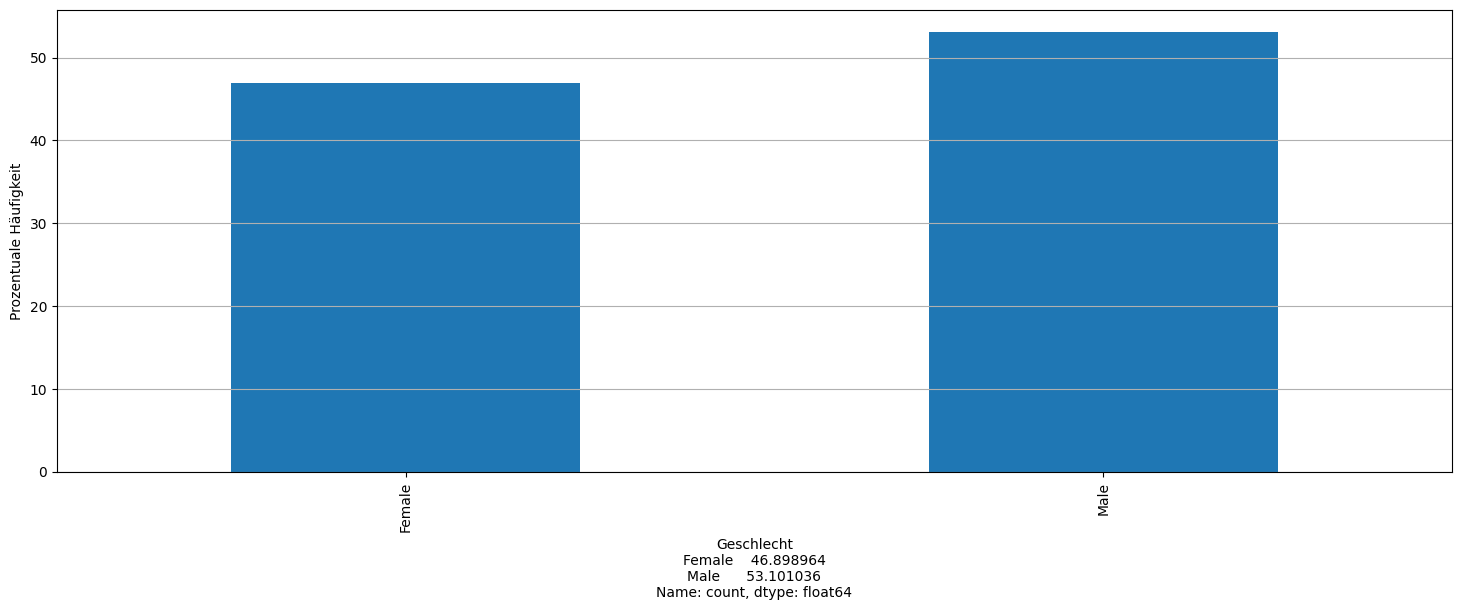

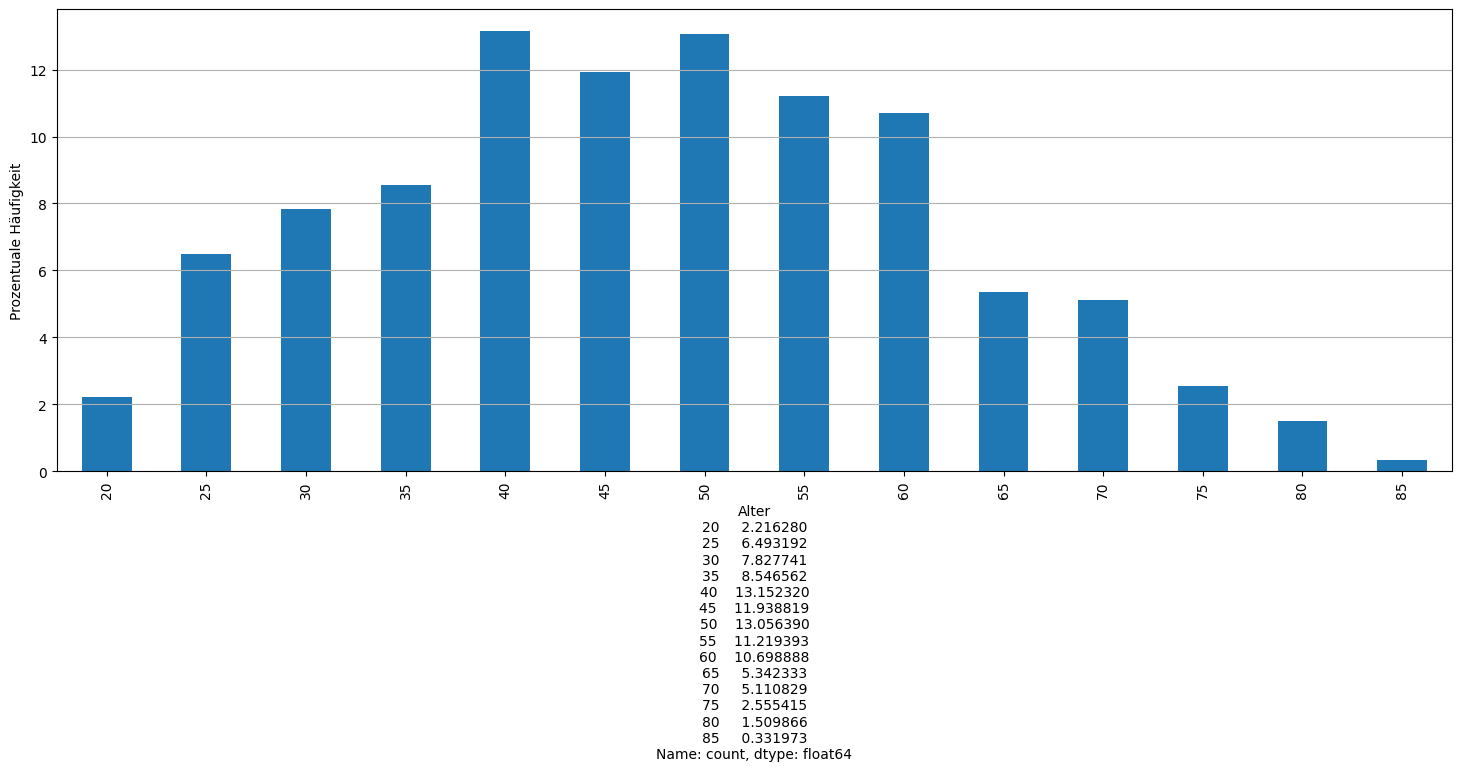

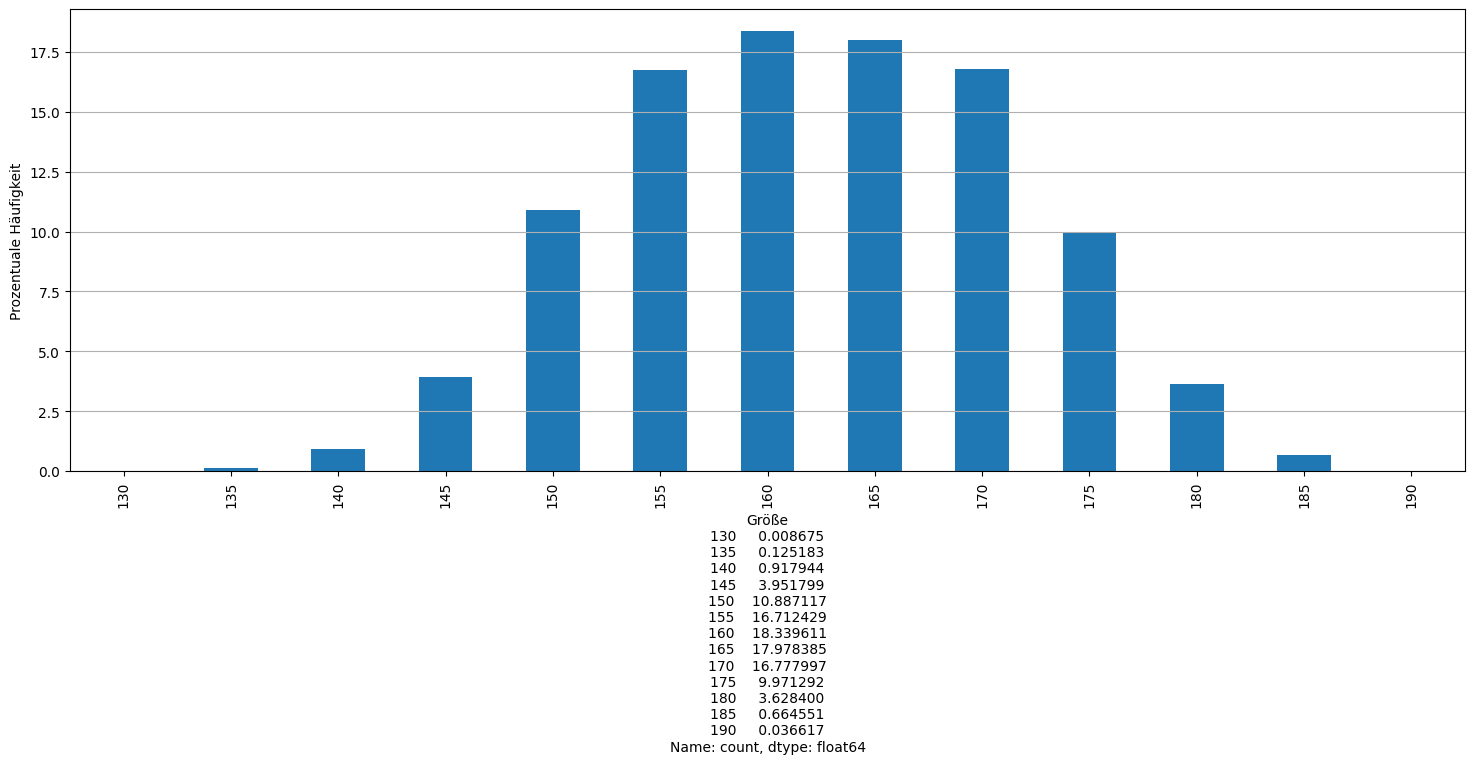

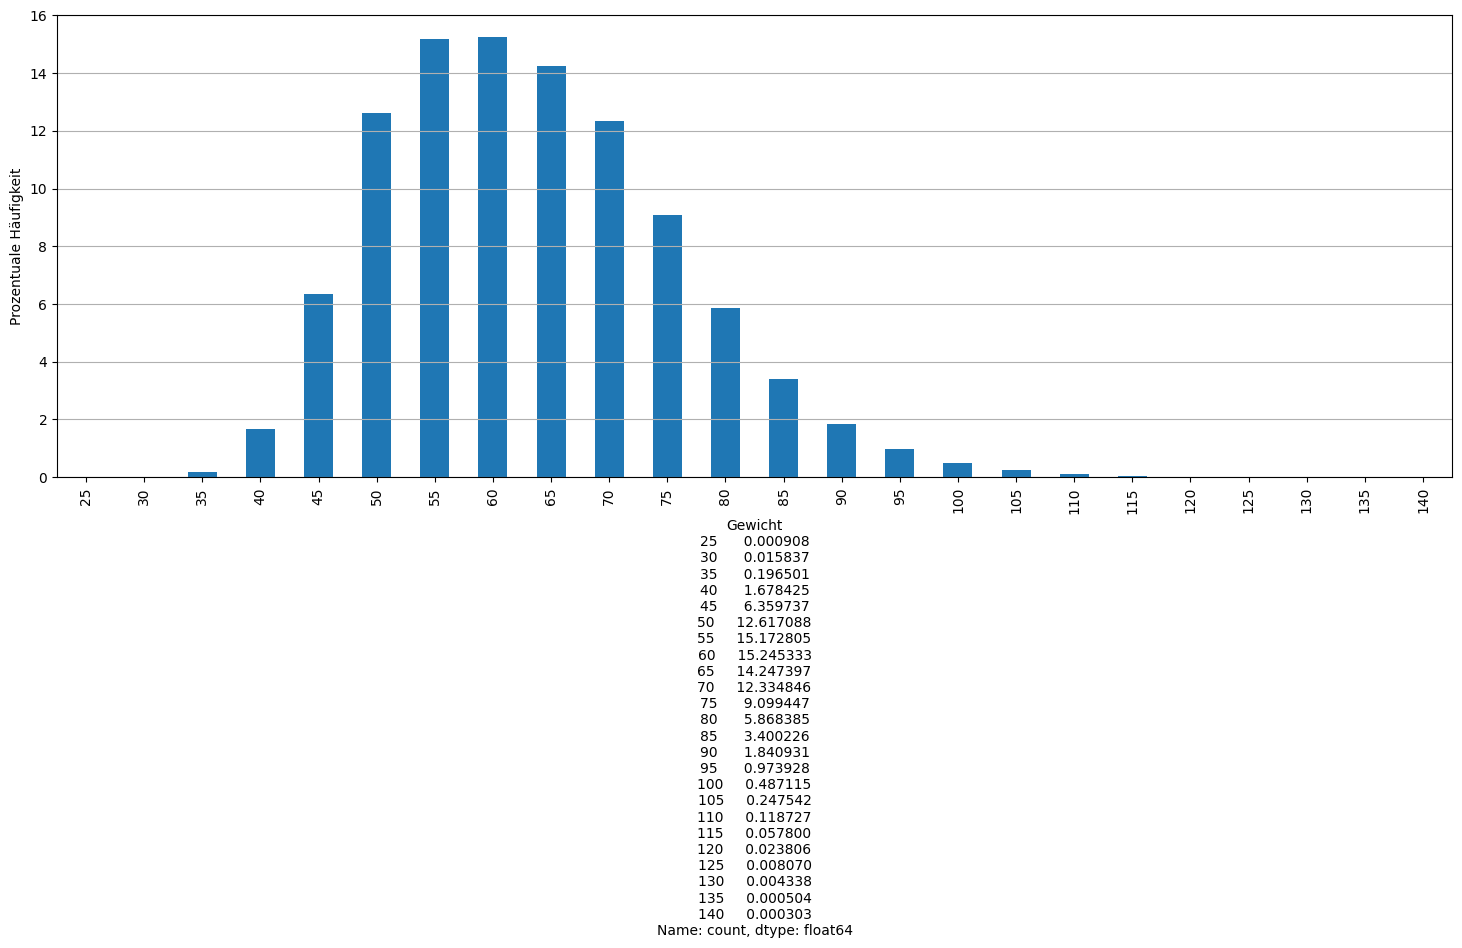

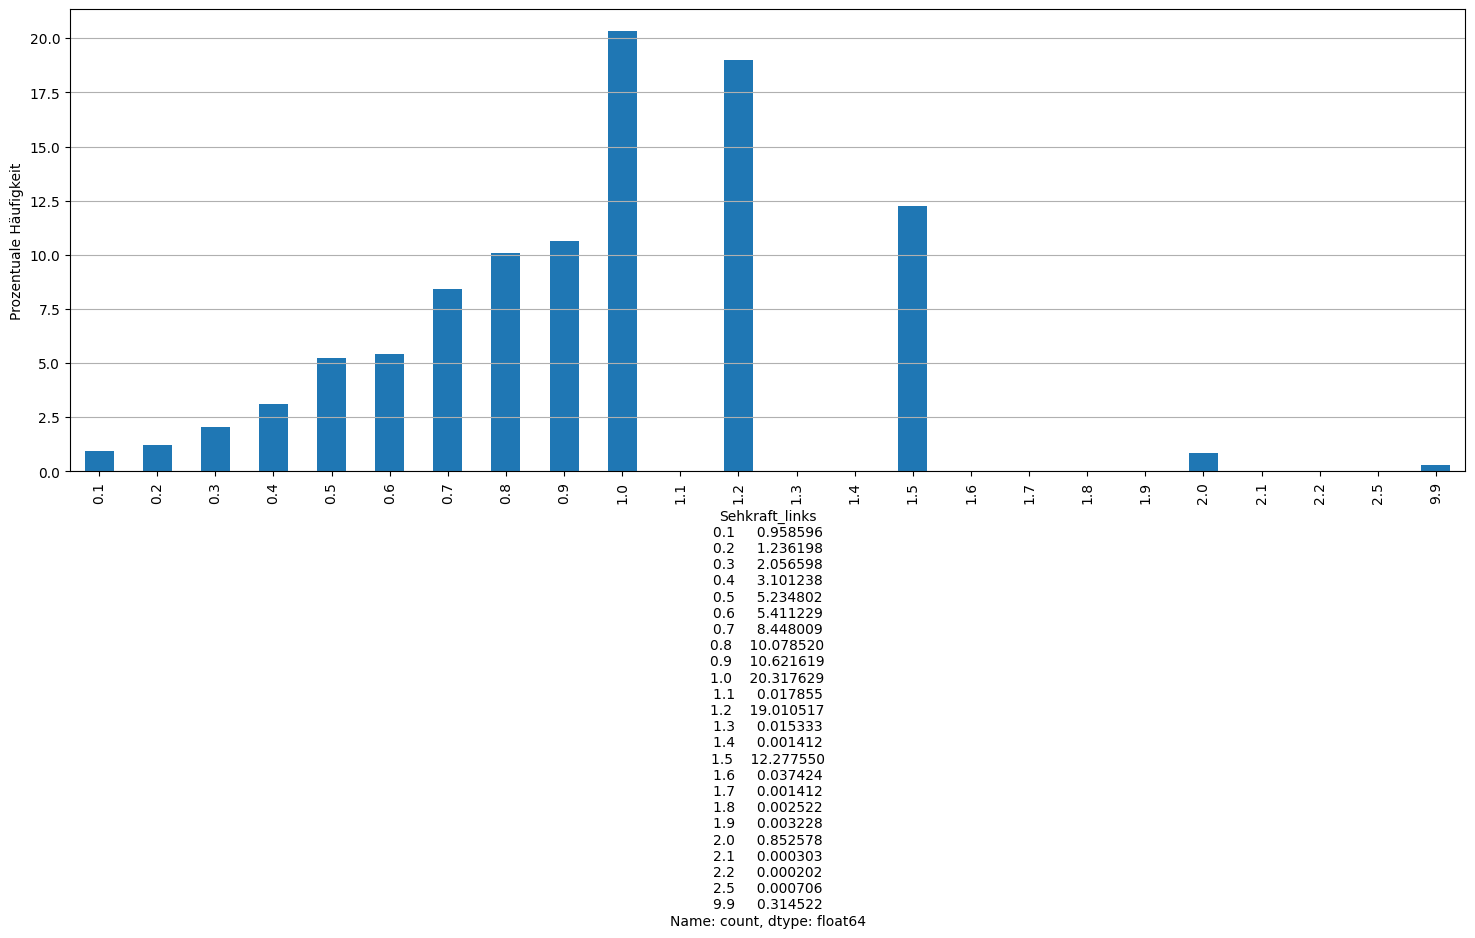

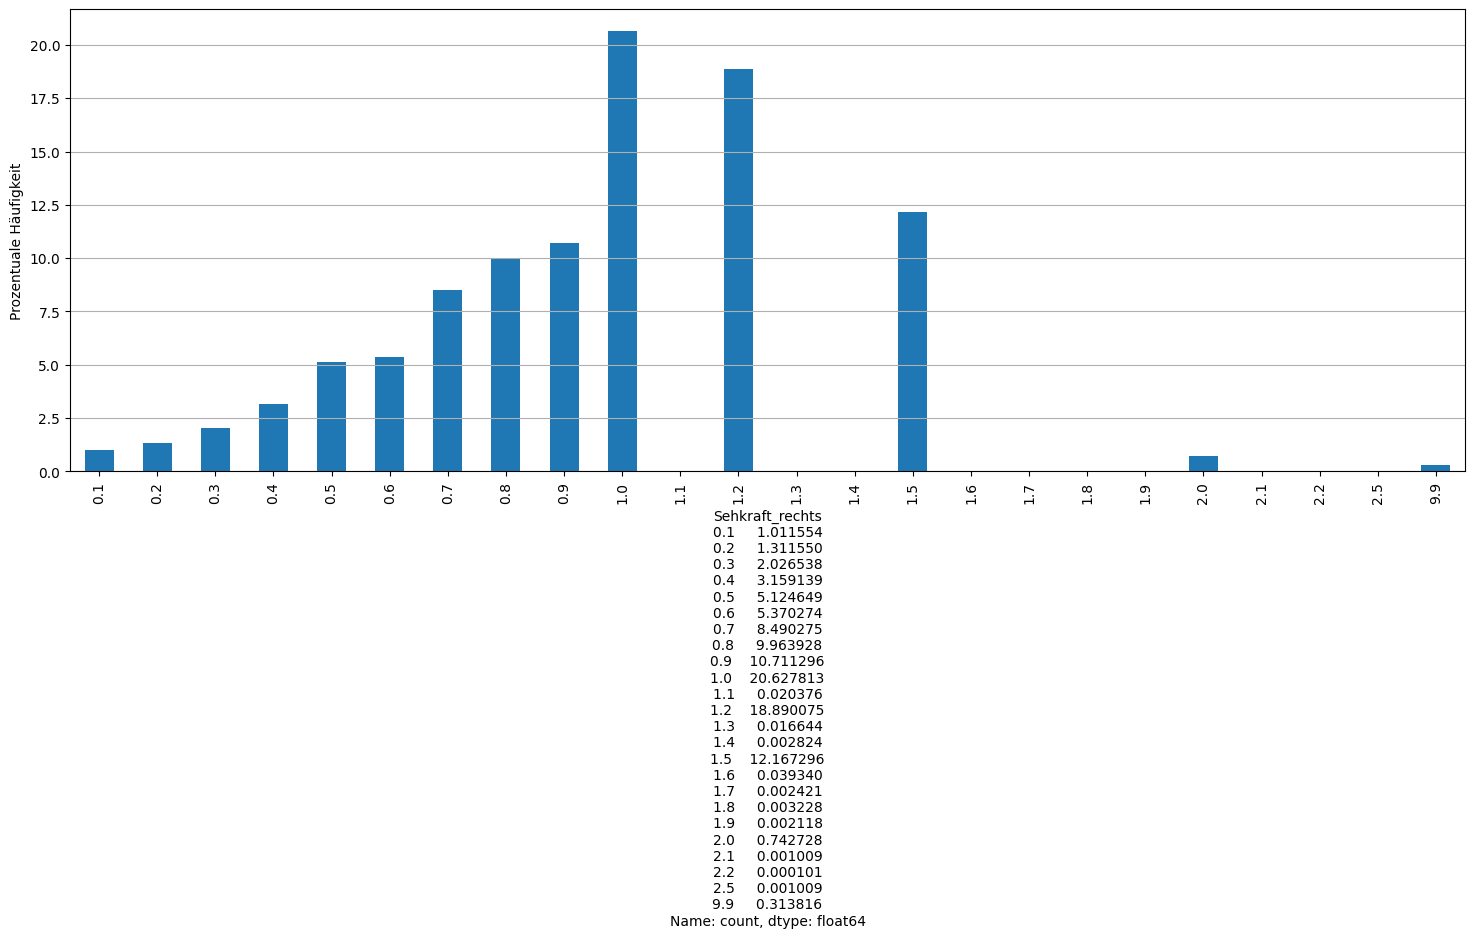

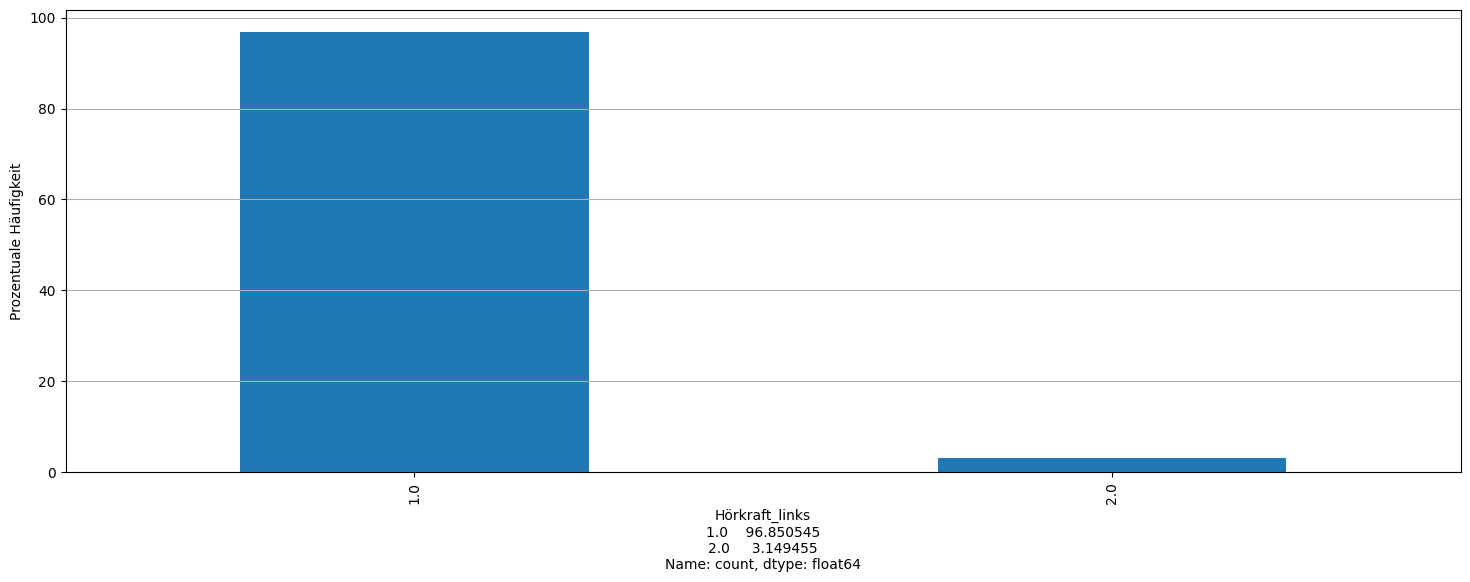

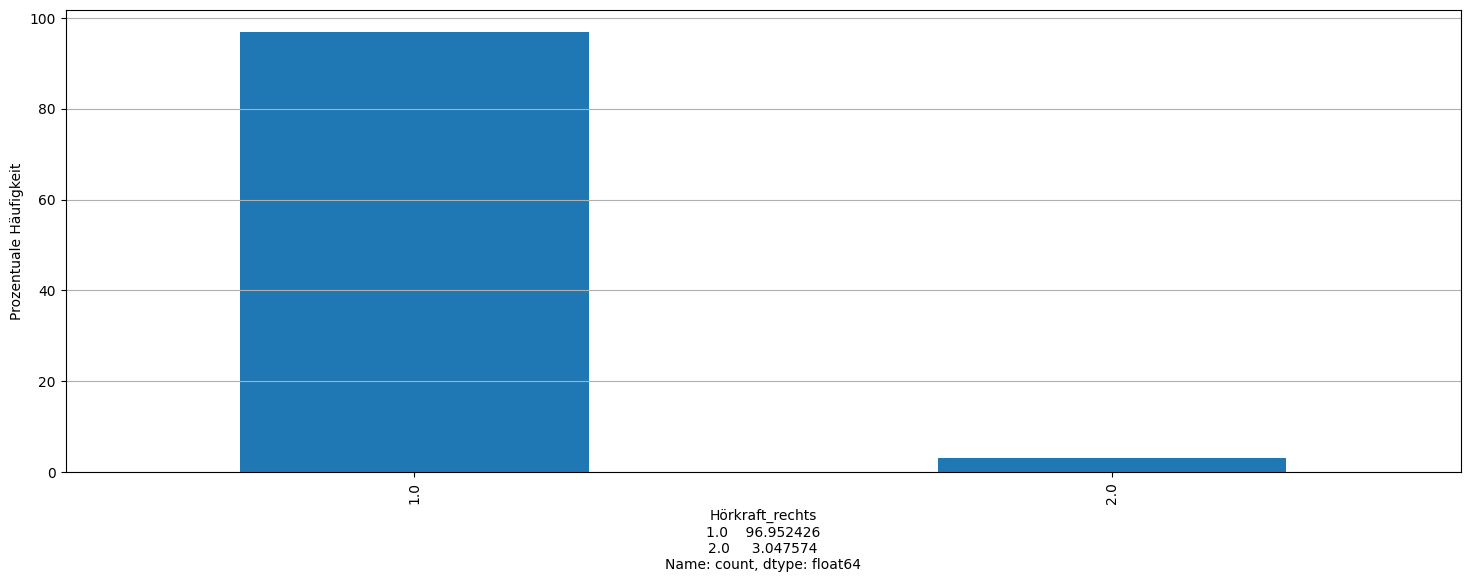

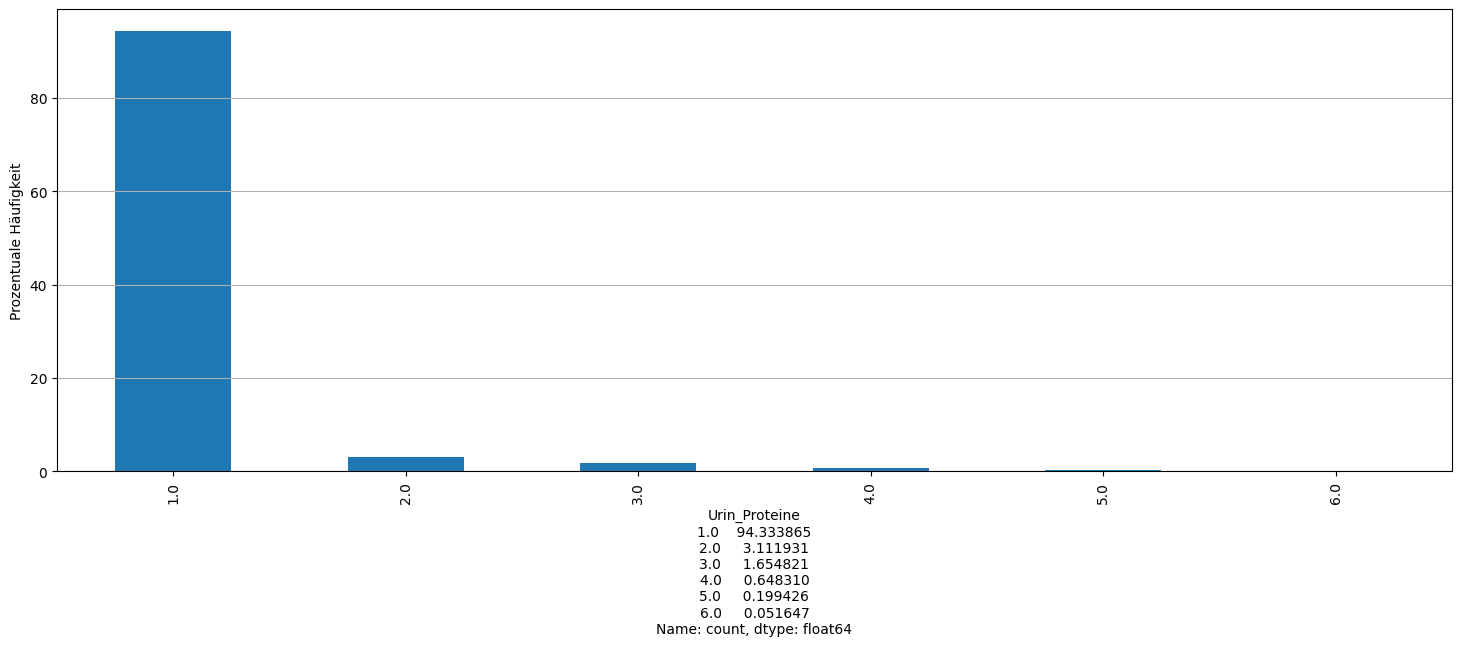

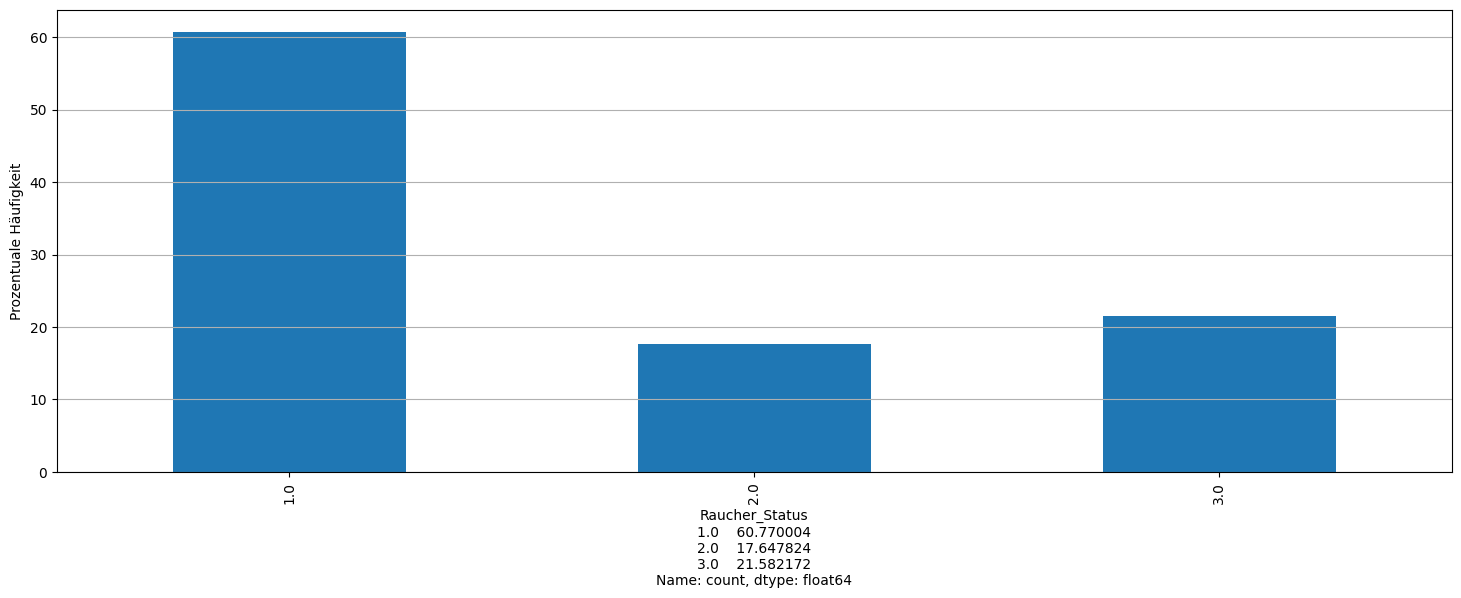

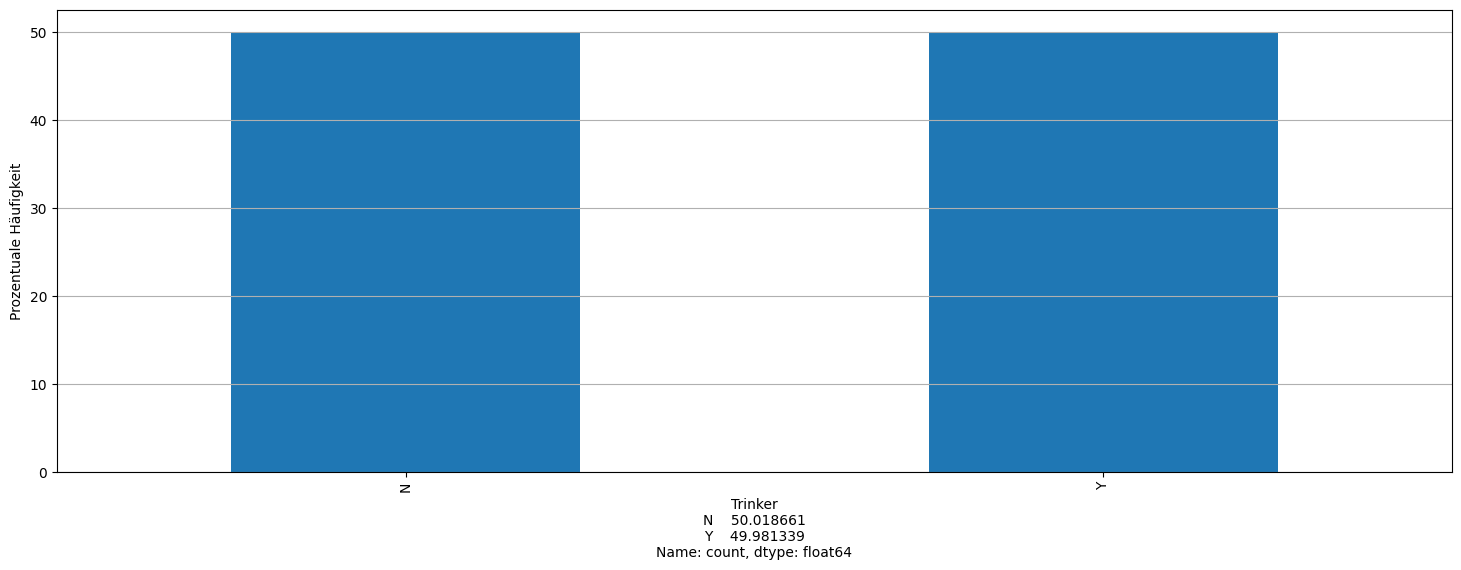

In [100]:
# Darstellen der Verteilung der jeweiligen Spalten:

dataset_columns_less = dataset.loc[:, dataset.apply(pd.Series.nunique) <= 30]

column_names_less = dataset_columns_less.columns.values.tolist()

for column in column_names_less:
    bar_chart(column)

In [101]:
# Funktion zum Darstellen der Verteilung der Werte einer Spalte als Boxplot:

def boxplot_chart(column):
    plt.figure(figsize=(18, 6)) 
    plt.boxplot(dataset[column], vert=False)
    plt.xlabel(column)
    plt.title('Boxplot')
    plt.show()

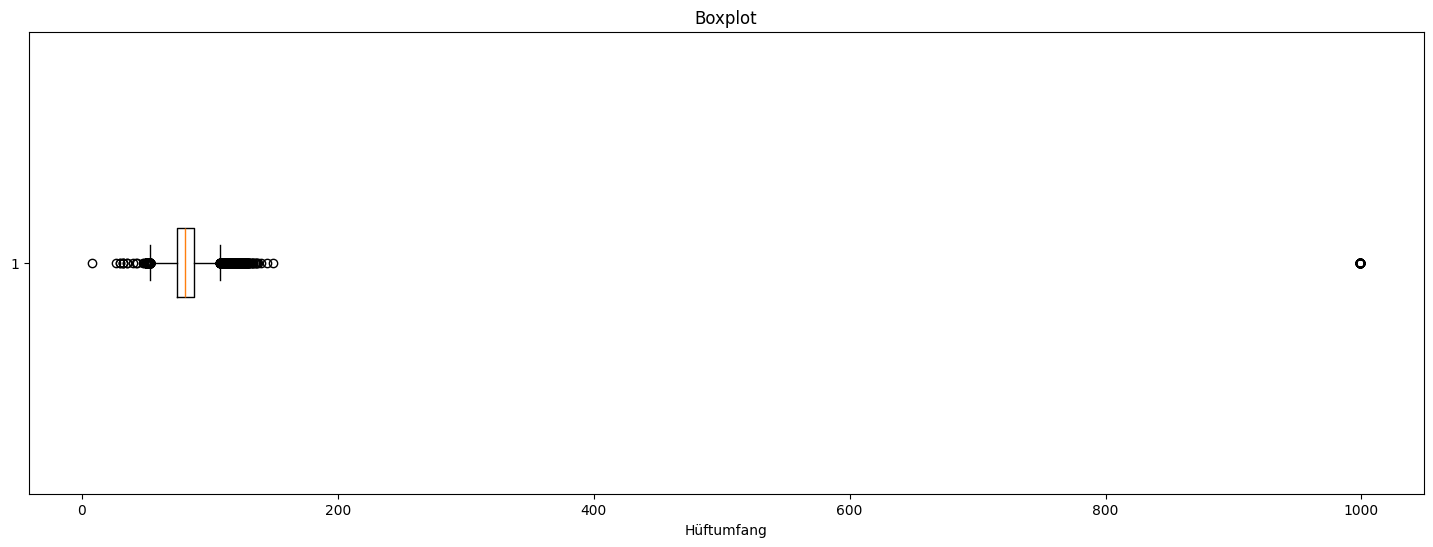

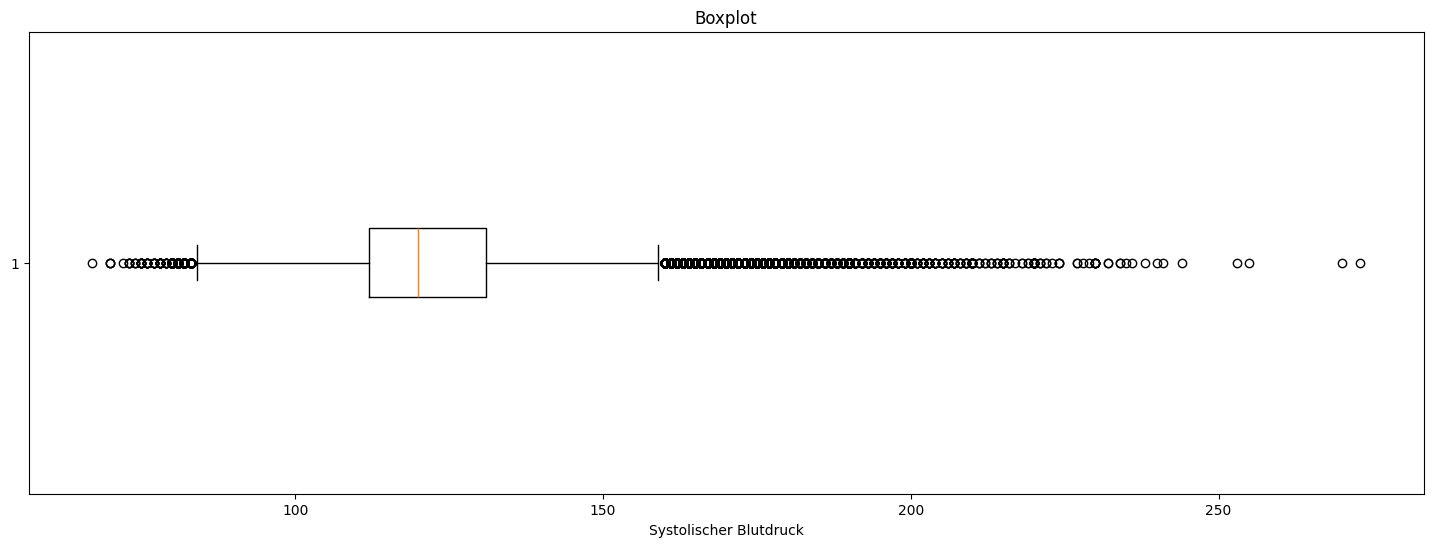

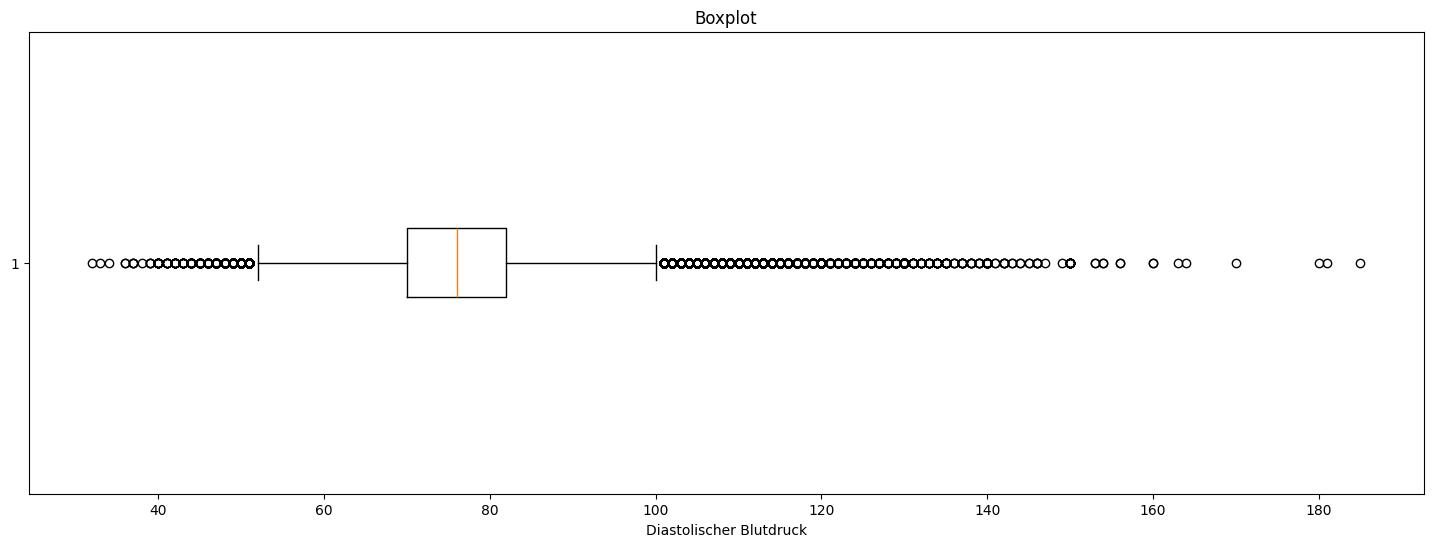

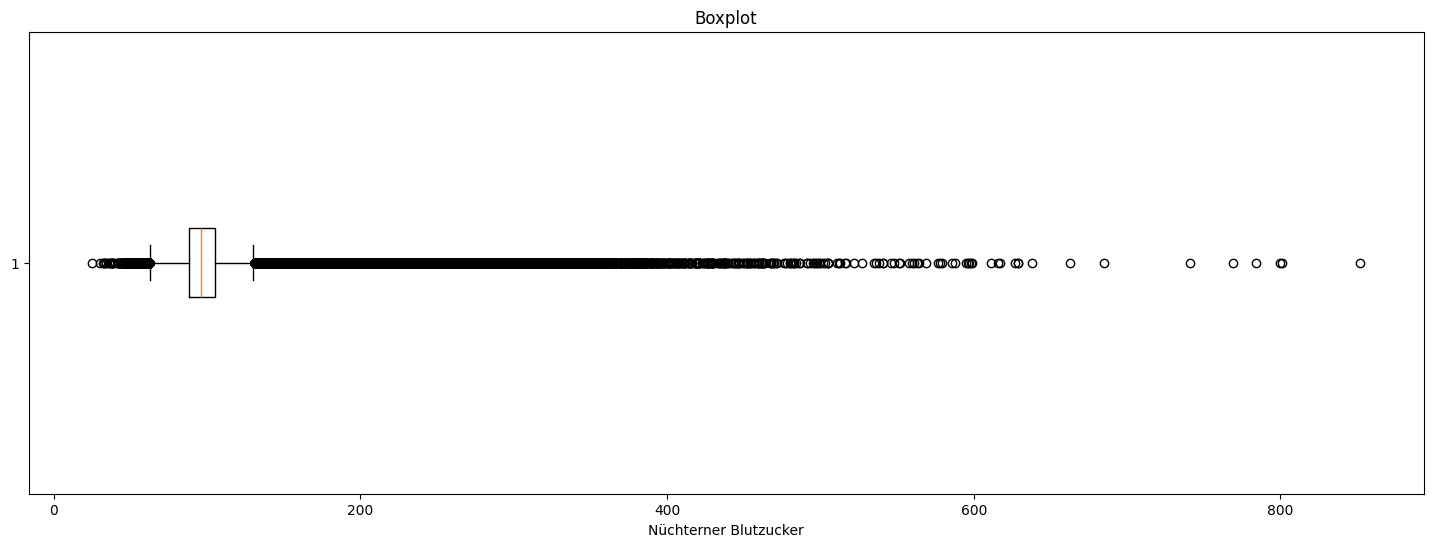

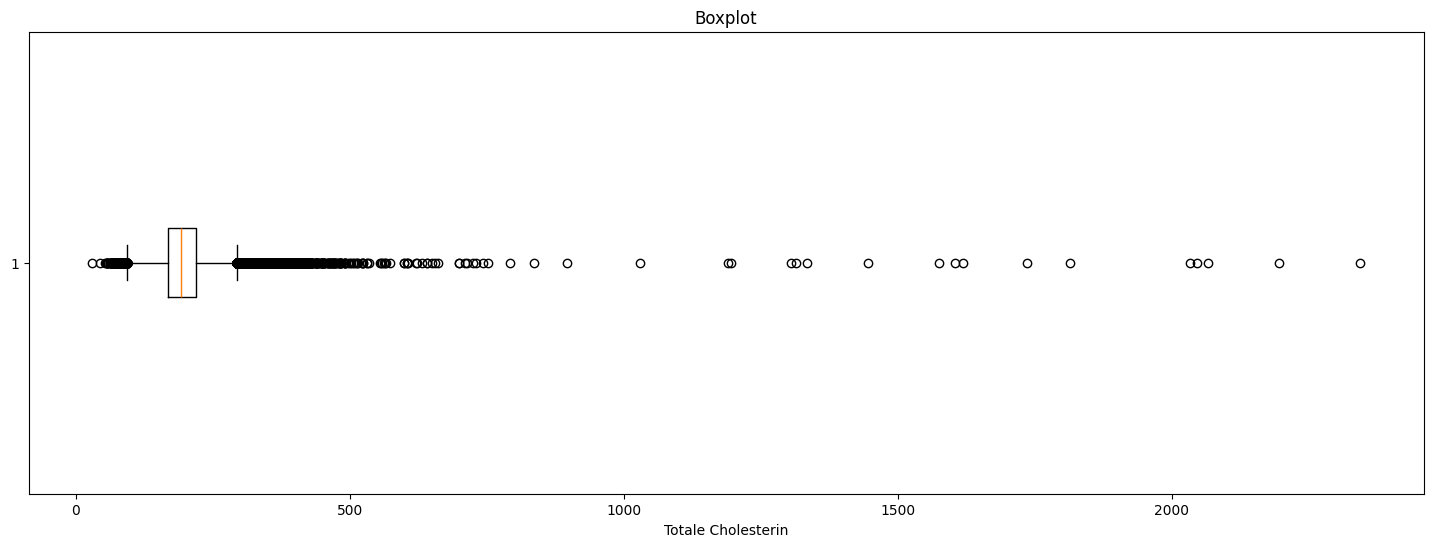

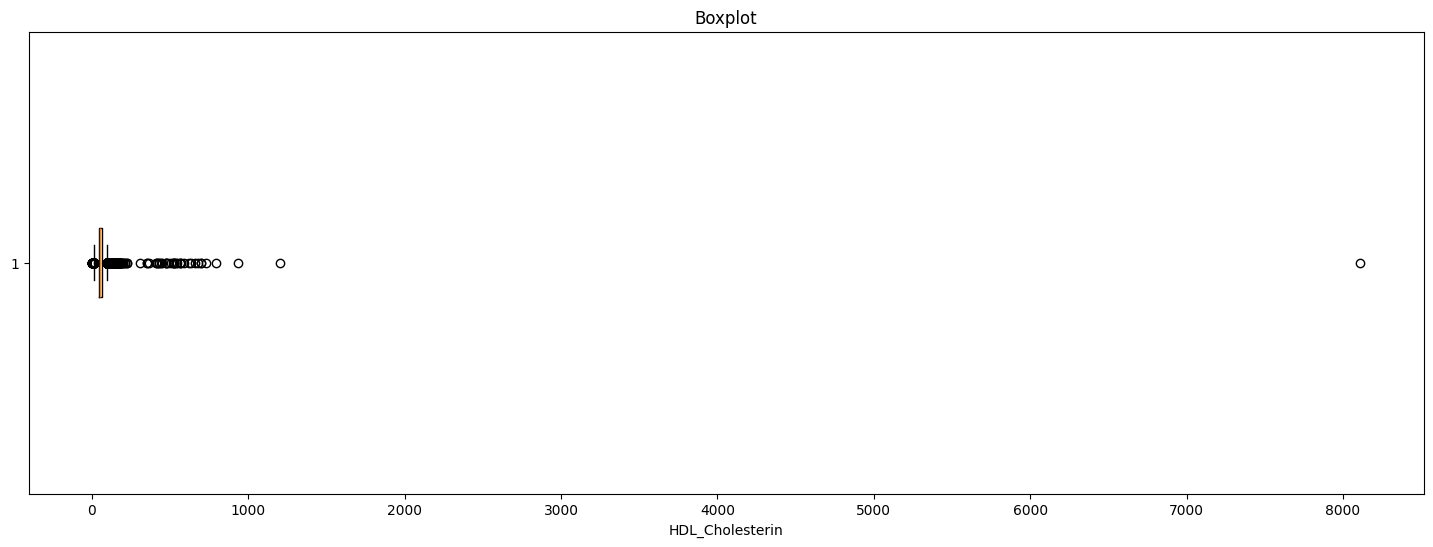

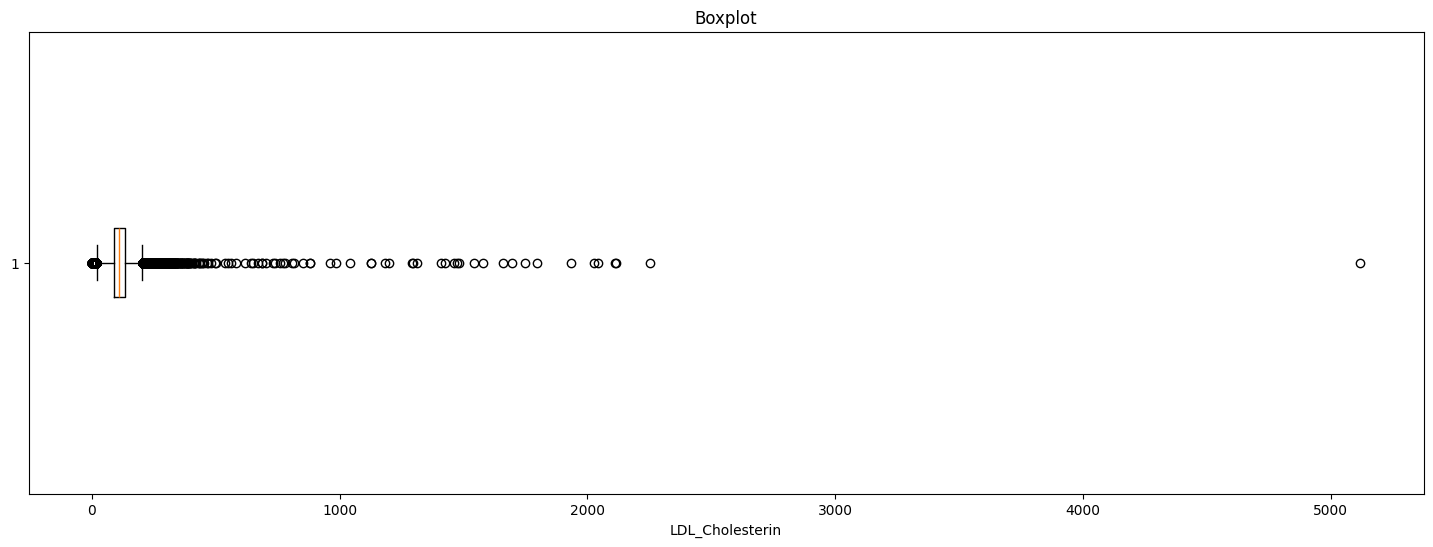

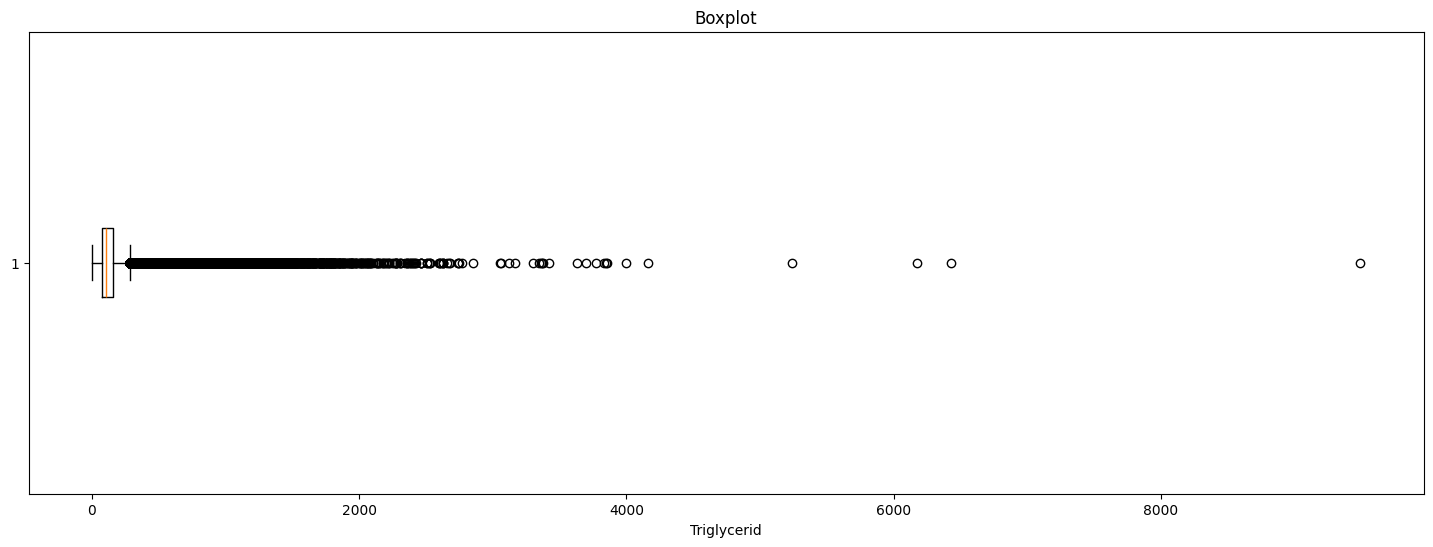

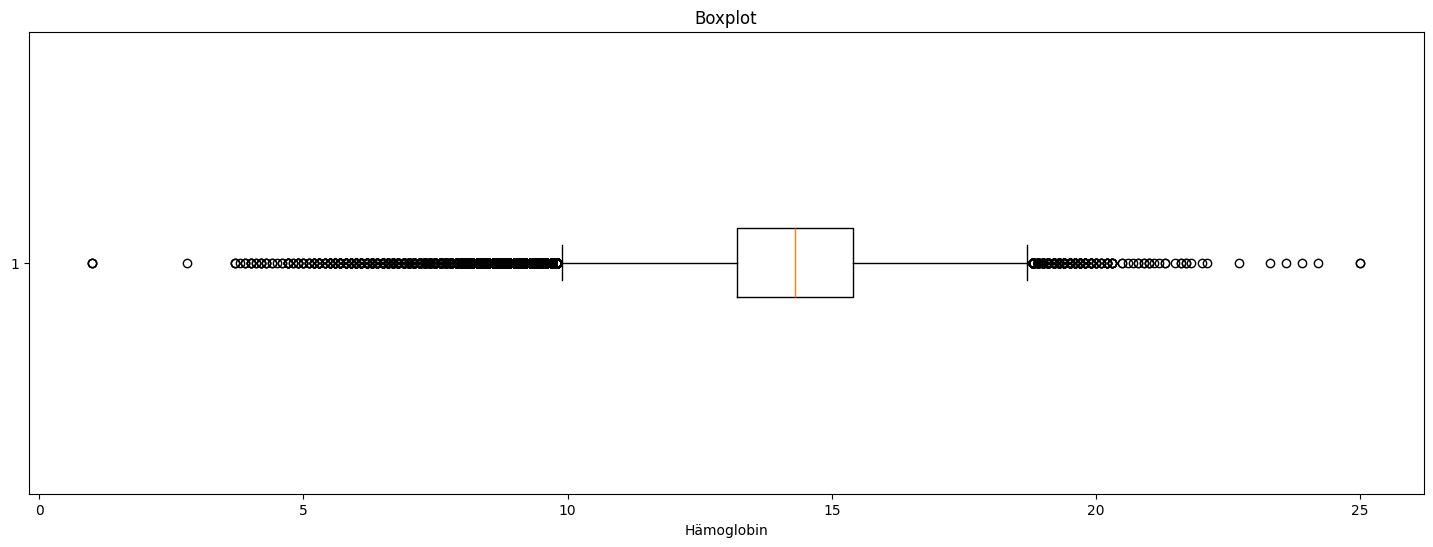

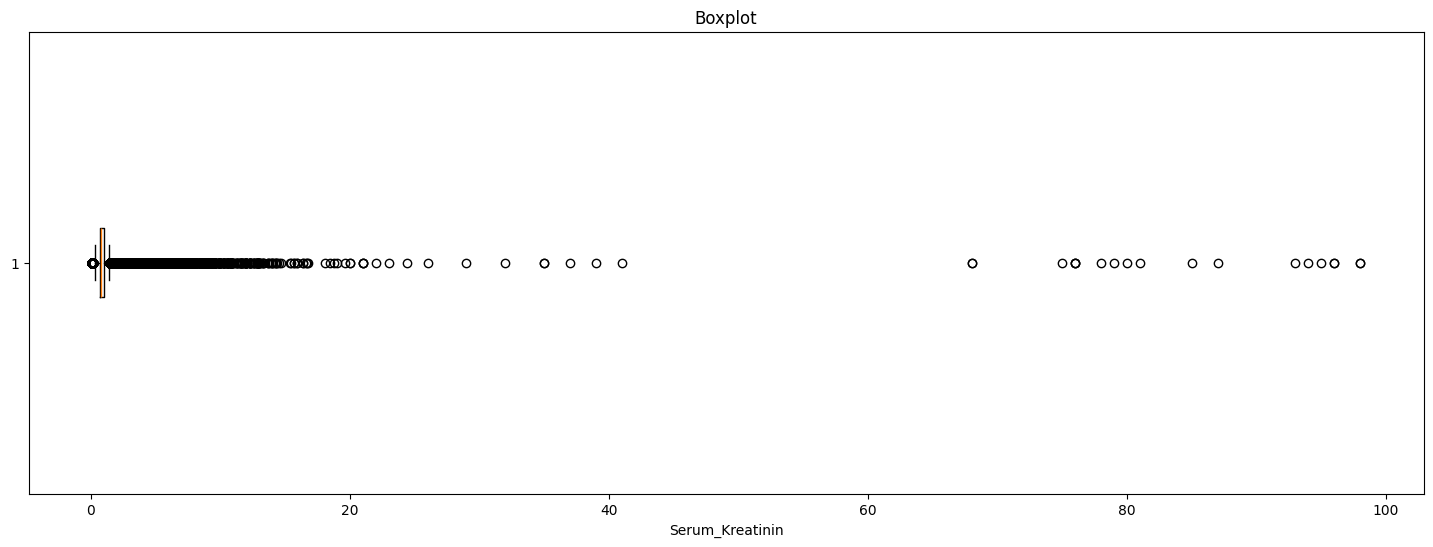

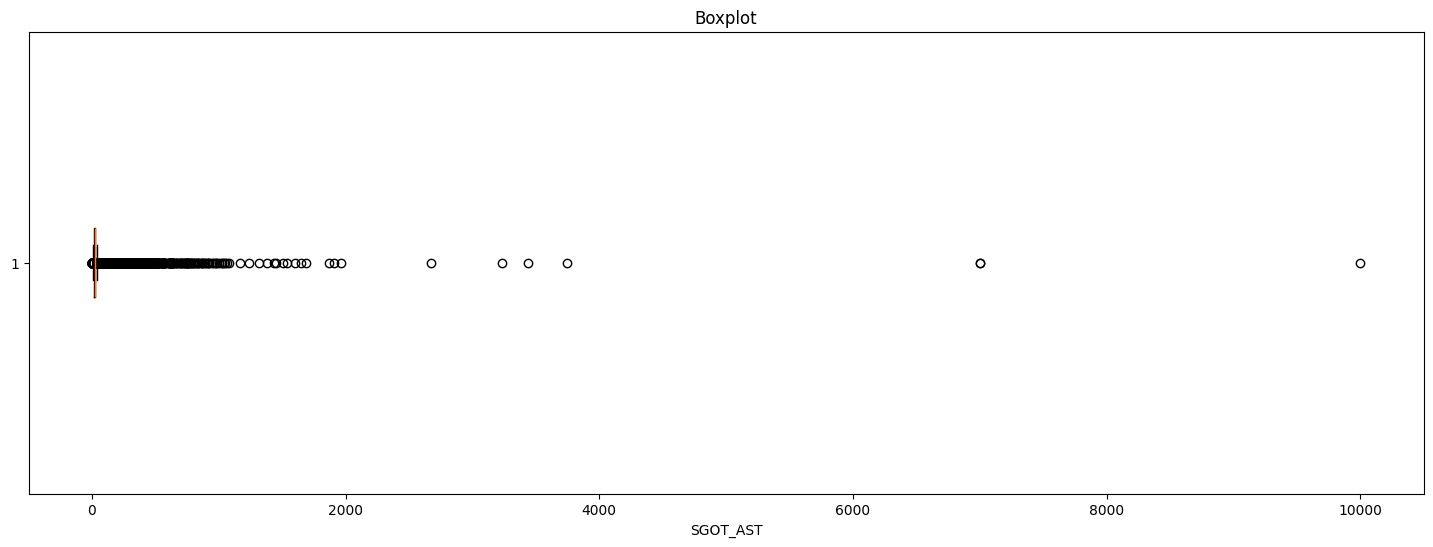

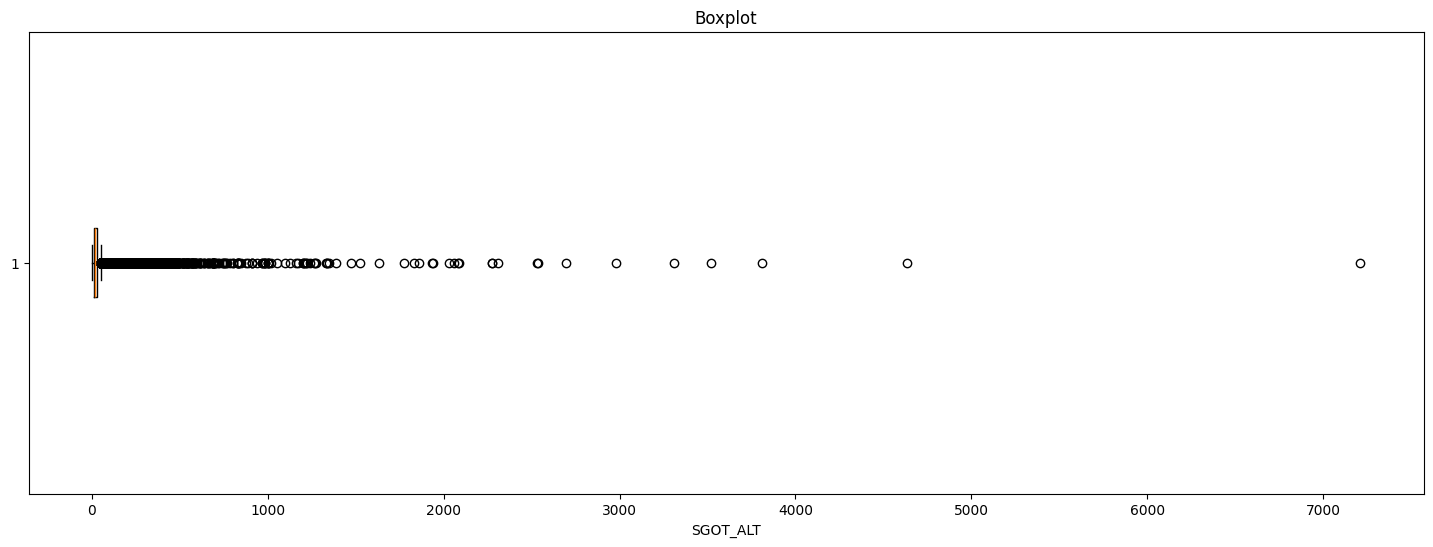

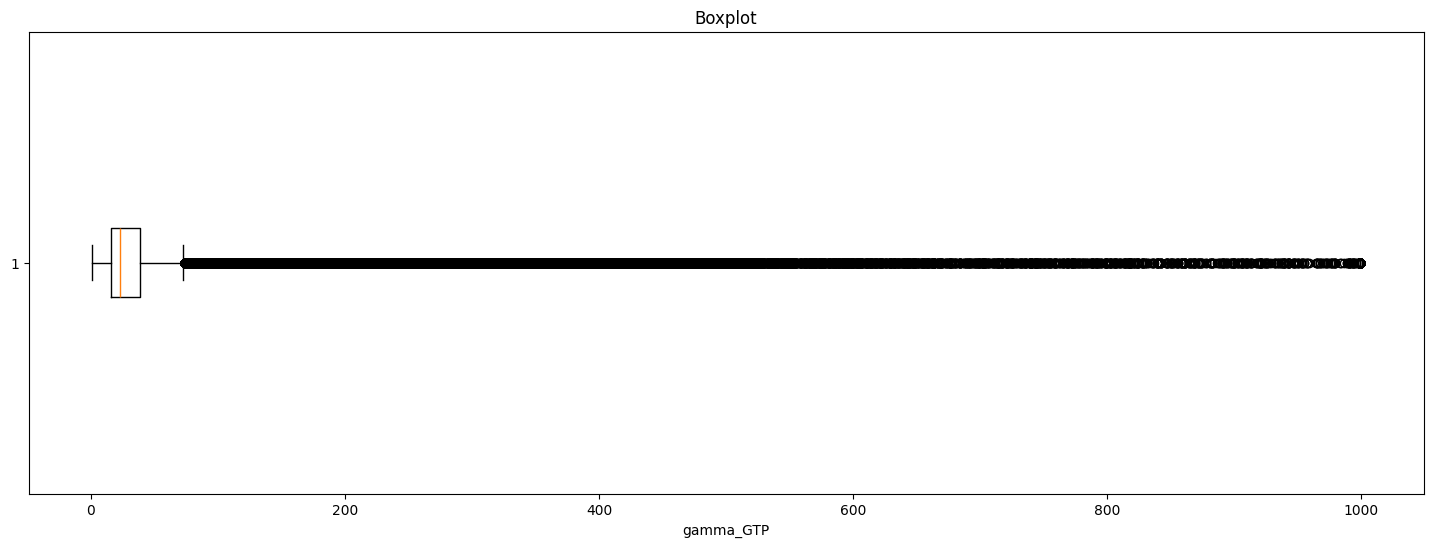

In [102]:
# Darstellen der Verteilung der jeweiligen Spalten:

dataset_columns_more = dataset.loc[:, dataset.apply(pd.Series.nunique) > 30]

column_names_more = dataset_columns_more.columns.values.tolist()

for column in column_names_more:
    boxplot_chart(column)

Die bereits erwähnten Auffälligkeiten zeigen sich auch über die Visualisierung wieder auf.

Diese werden in der Dokumentation genauer erläutert und bei Bedarf im folgenden Abschnitt bereinigt.

## 3. Data Preparation 

Zunächst werden die Datentypen der Spalten Geschlecht und Trinker zu Zahlenwerten transformiert.

In der Spalte Geschlecht nimmt die Ausprägung 'Male' dann den Wert 1 und 'Female' den Wert 0 an.

In der Spalte Trinker wird das 'Y' (für Yes) zu 1 und das 'N' (für No) zu 0.

In [103]:
# Transformieren der Spalte Geschlecht:

dataset['Geschlecht'] = dataset['Geschlecht'] == 'Male'
dataset['Geschlecht'] = dataset['Geschlecht'].astype(int)


# Transformieren der Spalte Trinker:

dataset['Trinker'] = dataset['Trinker'] == 'Y'
dataset['Trinker'] = dataset['Trinker'].astype(int)

Zudem werden hier neue Features definiert und dem Datensatz hinzugefügt.

In [104]:
# Hinzufügen der Spalte Body-Mass-Index:

BMI = dataset["Gewicht"].astype(np.float64) / ((dataset["Größe"].astype(np.float64) / 100) * (dataset["Größe"].astype(np.float64) / 100))

dataset["Body-Mass-Index"] = round(BMI, 2)

Die im Abschnitt Data Understanding identifizierten auffälligen Datenpunkte werden nun bereinigt.

In [105]:
# Eliminierung der fehlerhaften/falschen Daten und nicht benötigten Features:

dataset = dataset[dataset['Hüftumfang'] != 999]
dataset = dataset[dataset['HDL_Cholesterin'] < 1000]
dataset = dataset[dataset['LDL_Cholesterin'] < 2500]
dataset = dataset[dataset['Triglycerid'] < 3000]
dataset = dataset[dataset['gamma_GTP'] < 999]
dataset = dataset[dataset['SGOT_AST'] < 1000]
dataset = dataset[dataset['SGOT_ALT'] < 1000]

Da es in diesem Use-Case um die Klassifizierung der Raucher geht, können zudem Spalten eliminiert werden, die nicht mit diesem Feature korrelieren.

Durch die Transformation der Datentypen der Spalten Geschlecht und Trinker kann folgend eine Korrelationsmatrix dargestellt werden.

In [106]:
# Funktion zum Darstellen der Korrelation der Werte mehrerer Spalten:

def corrmap(columns):
    plt.figure(figsize=(20, 18))
    data = dataset[columns]
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

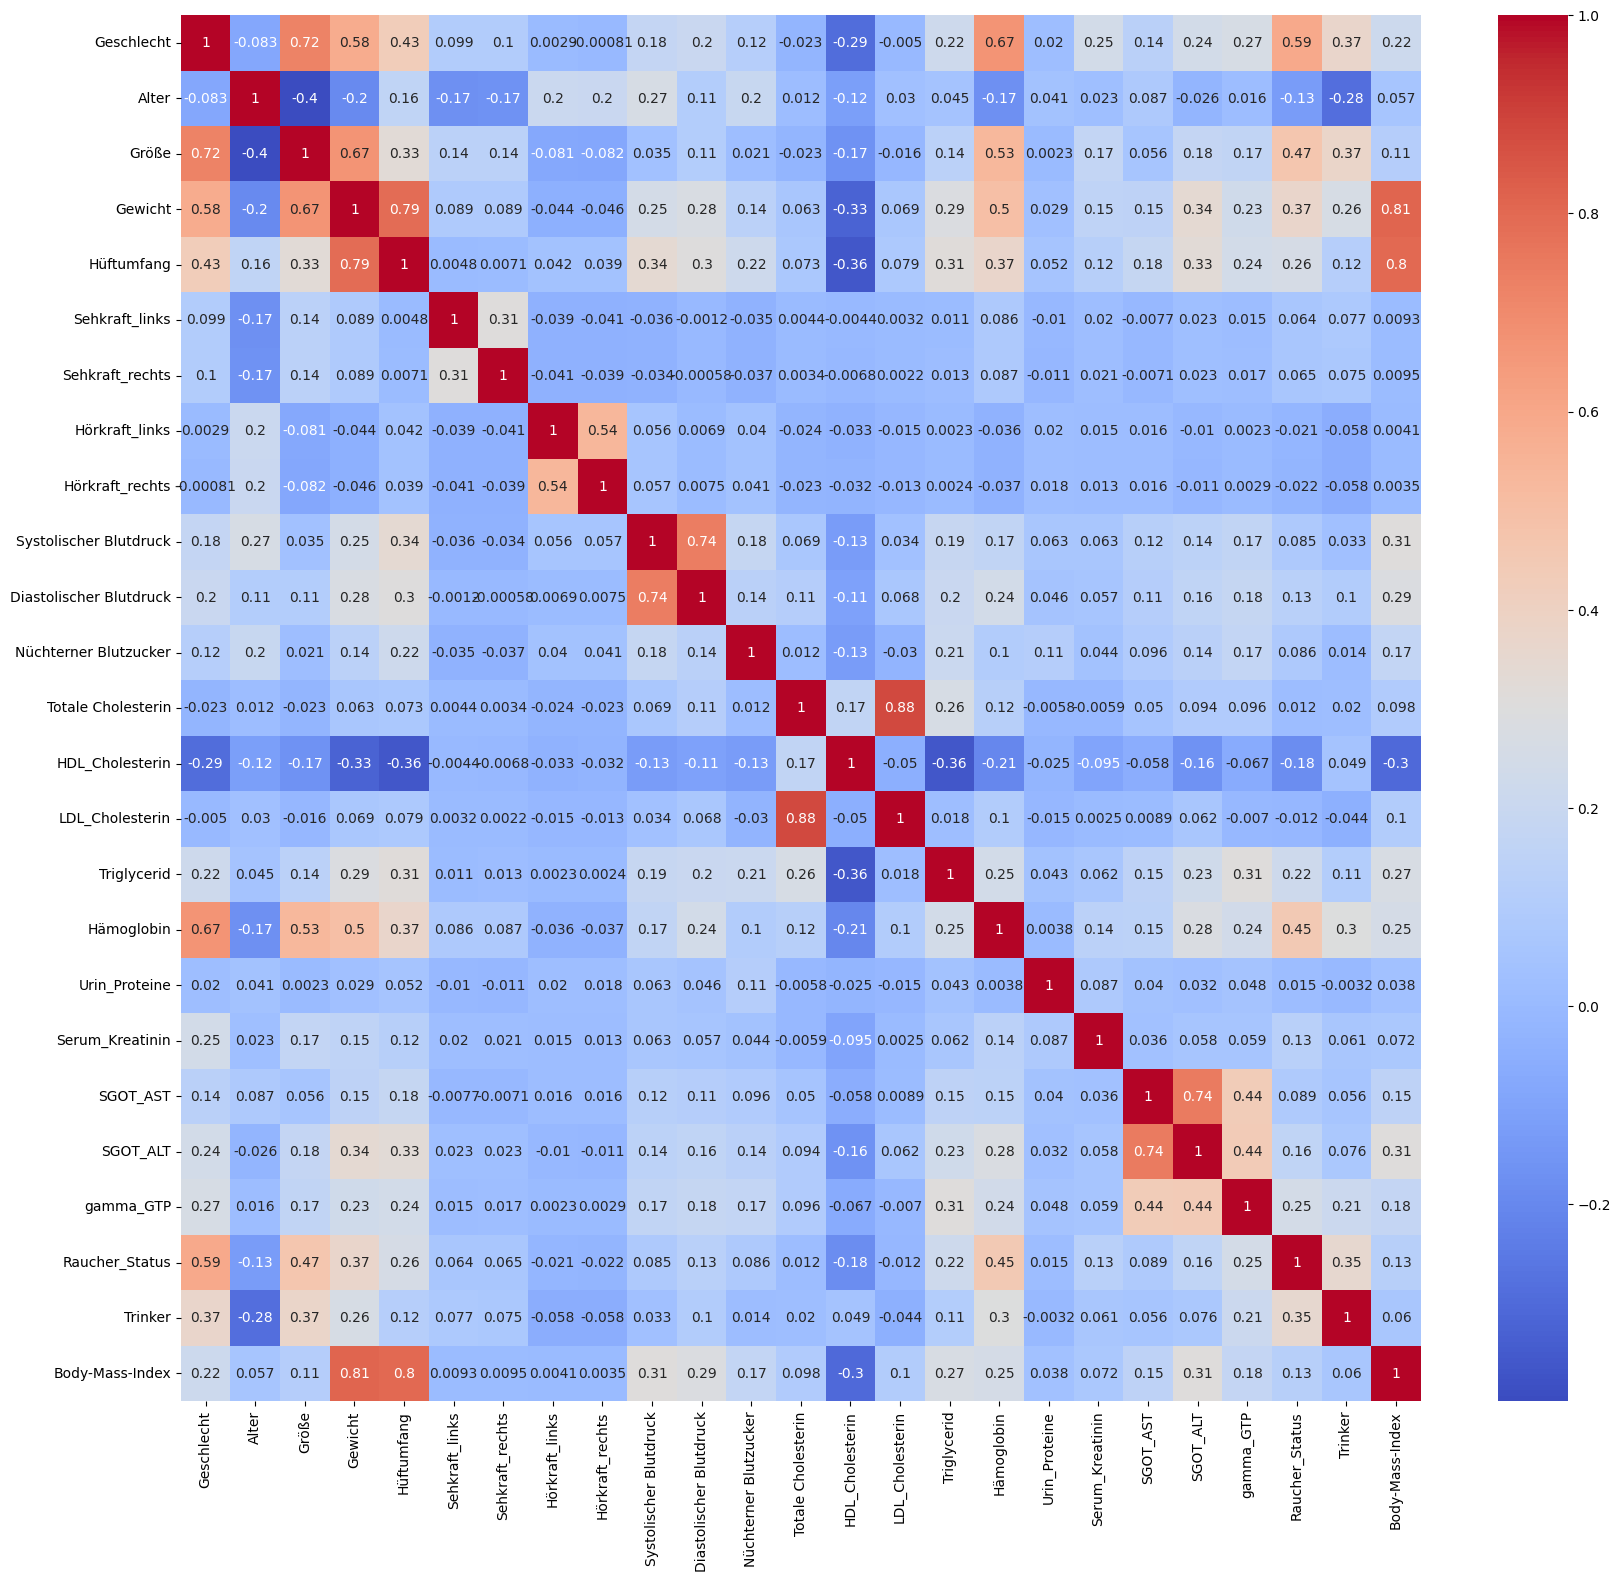

In [107]:
column_names = dataset.columns.values.tolist()

corrmap(column_names)

Die folgenden Spalten korrelieren nur sehr gering mit dem Feature Raucher_Status und werden deshalb eliminiert.

- Sehkraft_links 
- Sehkraft_rechts 
- Hörkraft_links 
- Hörkraft_rechts 
- Systolischer Blutdruck 
- Diastolischer Blutdruck 
- Nüchterner Blutzucker 
- Totale Cholesterin 
- HDL_Cholesterin 
- LDL_Cholesterin 
- Urin_Proteine 
- Serum_Kreatinin 
- SGOT_AST 
- SGOT_ALT 
- Body-Mass-Index

In [108]:
# Eliminieren der Spalten:

dataset = dataset.drop(columns=['Sehkraft_links', 'Sehkraft_rechts', 'Hörkraft_links', 'Hörkraft_rechts', 'Systolischer Blutdruck', 'Diastolischer Blutdruck', 'Nüchterner Blutzucker', 'Totale Cholesterin', 'HDL_Cholesterin', 'LDL_Cholesterin', 'Urin_Proteine', 'Serum_Kreatinin', 'SGOT_AST', 'SGOT_ALT', 'Body-Mass-Index'])

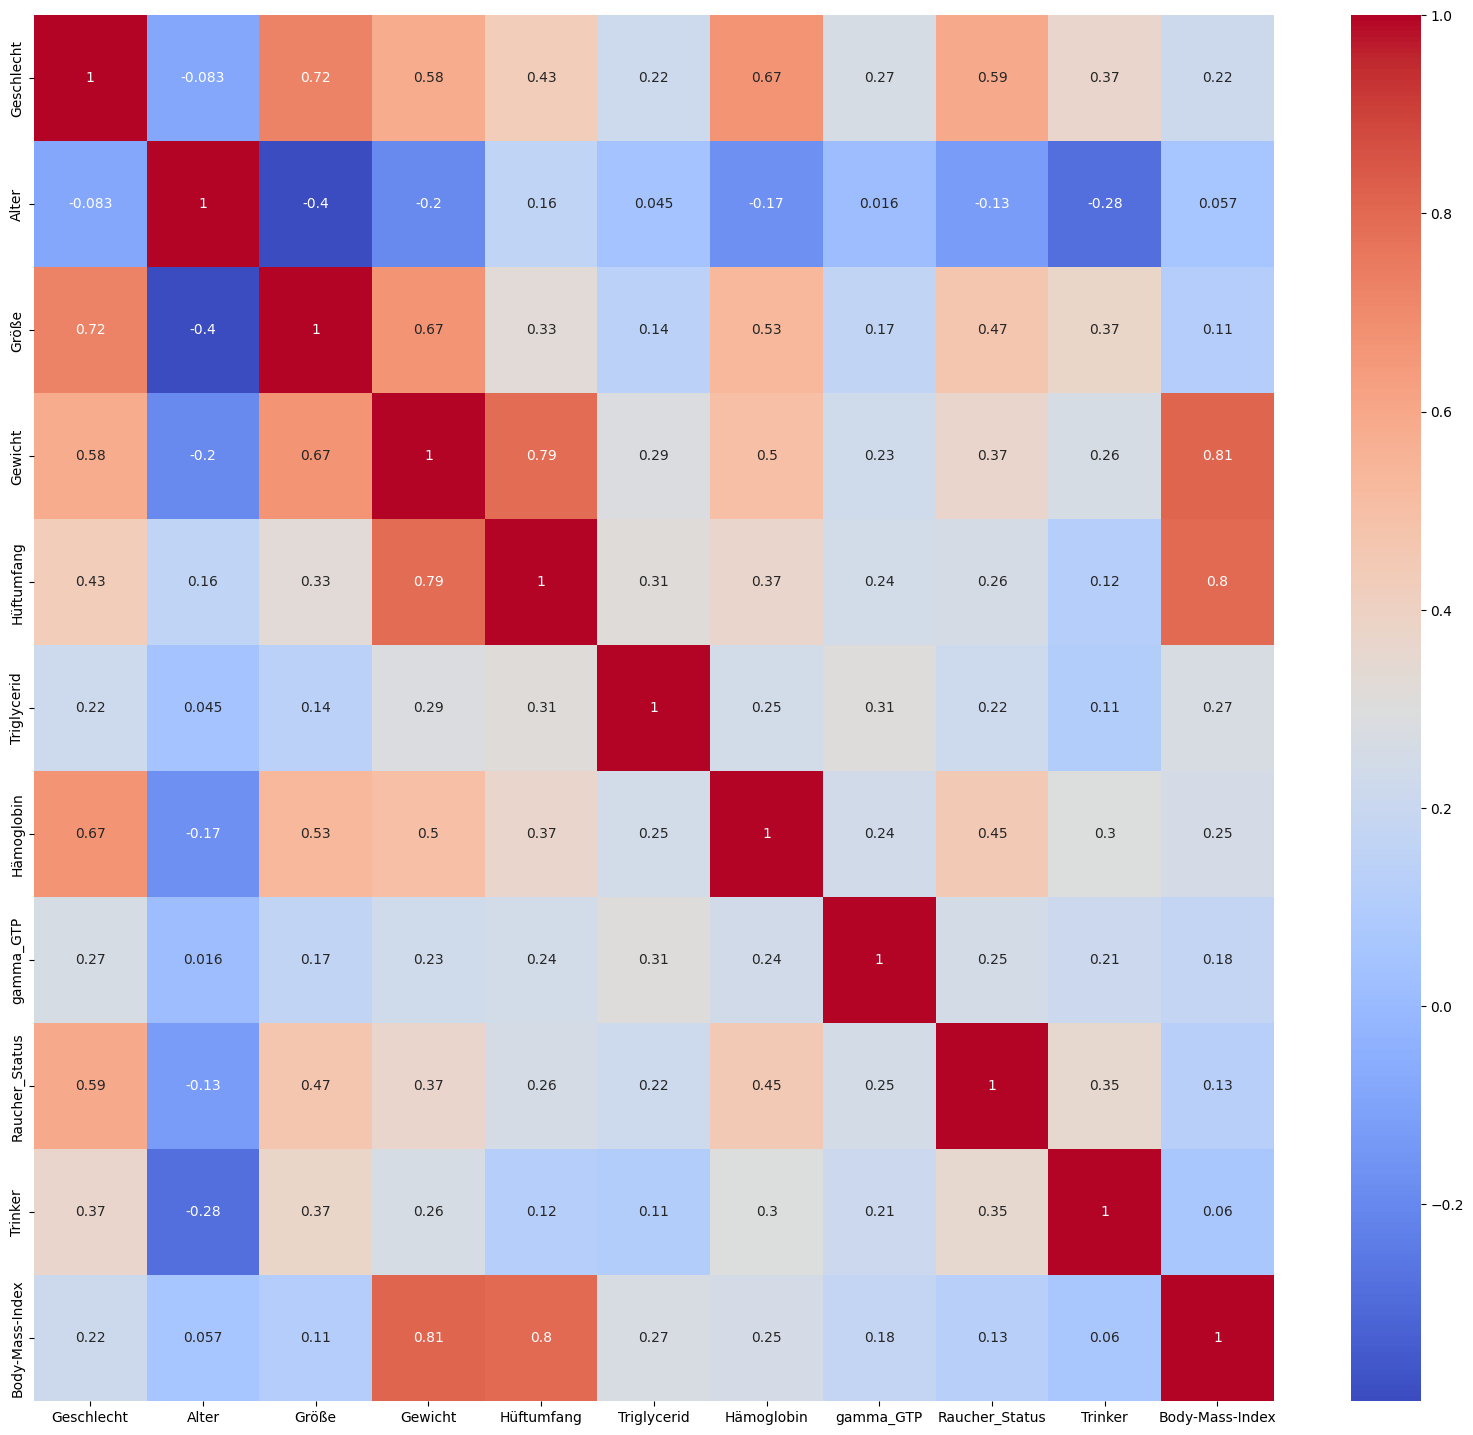

In [109]:
# Erneute Darstellung der Korrelation:

column_names = dataset.columns.values.tolist()

corrmap(column_names)

Zudem gilt es zu betrachten, dass es aus biologischer Sicht einen wesentlichen Unterschied in Bezug auf die Ausprägungen der einzelnen Features gibt, ob ein Proband männlich oder weiblich ist. 

Für die folgenden Analysen wird der bestehende Datensatz deshalb aufgeteilt.

In [53]:
# Trennung in des Dataset in Frauen und Männer
dataset_male = dataset[dataset['Geschlecht'] == 1]

dataset_female = dataset[dataset['Geschlecht'] == 0]

Nun sollten die Datensätze erneut auf Auffälligkeiten geprüft werden.

Im Rahmen dieser Projektarbeit verlief der gesamte Entwicklungsprozess iterativ. Dies hier darzustellen würde jedoch für eine unübersichtliche Struktur sorgen, weshalb darauf verzichtet wird.

## 4. Modeling

## 5. Evaluation

## 6. Deployment

Da das Modell nun fertig trainiert und evaluiert wurde, muss es nun dem Business-User zur Verfügung gestellt werden.
Hierfür gibt es mehrere Möglichkeiten. 

Eine Möglichkeit wäre es, das Modell über die 'Azure Machine Learning' - Plattform von Microsoft zu hosten, sodass es über einen REST-Endpunkt verfügbar gemacht werden kann.

Basierend auf diesem Endpunkt könnte dann eine Web-Anwendung entwickelt werden, in der die benötigten Features eingetragen werden können, sodass dann das Ergebnis der Klassifikation zurückgegeben wird.

Ein weiterer Aspekt, den es hierbei zu Berücksichtigen gibt is MLOps.
Hierbei geht es zudem um die Maintainance des Modells und die Verfügbarkeit.

Es muss darauf geachtet werden, dass das Modell dem aktuellen Stand der Daten entspricht, was bedeutet, dass dieses immer wieder neu trainiert werden sollte, sodass sich die Genauigkeit über die Zeit erhöht.

Zudem sollte es stets verfügbar sein, wenn es von einem Anwender benötigt wird.